# Flow Matching

This afternoon we're going to be working with the _same_ dataset as yesterday in Annalena's tutorial with binary black hole (BBH) merger, but... using a **continous normalizing flow** trained with the **flow matching loss** instead of the discrete normalizing flows from yesterday.

<img src="Two_merging_black_holes.jpg.png"  width="300" height="200">

Photo credit [ESA](https://www.esa.int/ESA_Multimedia/Images/2019/05/Two_merging_black_holes)

**Resources:** 
The data loading is the same as yday and comes from Annalena's nb, and also code for this notebook comes from some excellent flow matching tutorials:
- Carol's PALMS tutorial:
- Lukas's notebooks:

**Prerequisites:**
- Step X of this tutorial is going to look at the _likelihood_ of the trained model.
- To do this, you'll need to _integrate_ the neural ODE
- We assume you've already learned how to do this in this mornings `conditional_normalizing_flow.ipynb` tutorial, so if you haven't done this yet, just take some time to go back and learn that step before diving into the flow matching jazz :)


**Table of Contents:**
- Q1/
- Q2/
- Q3/


Nicole Hartman

ODSL GenAI Days

24 Sept 2024

In [4]:
import os
import matplotlib.pyplot as plt
import numpy as np
import pickle
import torch
import corner

from torch.utils.data import Dataset, DataLoader, random_split

In [5]:
# If running on Apple Silicon or CUDA is available, use the GPU.

if torch.backends.mps.is_available():
    device = "mps"
elif torch.cuda.is_available():
    device = "cuda"
else:
    device = "cpu"

In [6]:
print(device)

mps


### Data loading and preprocessing for training
In this notebook, we will load and preprocess the data generated with the notebook `data_generation.ipynb` and saved as `data/training_dataset.pkl`.

In [8]:
data_folder = '../01_normalizing_flows/data'
file_name = os.path.join(data_folder, 'dataset.pkl')

if not os.path.isfile(file_name):
    raise ValueError(f"File {file_name} does not exist, correct path or generate data set.")

with open(file_name, 'rb') as f:
    data = pickle.load(f)
print('Sucessfully loaded dataset with', len(data['hp']), 'waveforms.')

Sucessfully loaded dataset with 10000 waveforms.


Load in a pytorch Dataset and do the dataset preprocessing

In [110]:
class WaveformDataset(Dataset):
    
    def __init__(self, data):
        '''
        - data: As loaded from what we've saved from the 
                data_generation nb
        '''

        parameters = torch.FloatTensor(data['masses'])
    
        # Standardize masses for training
        self.parameters_mean = torch.mean(parameters, axis=0)
        self.parameters_std = torch.std(parameters, axis=0)
        
        parameters_standardized = (parameters - self.parameters_mean) / self.parameters_std
                
        '''
        Pre-process waveforms: 
        - truncate below f_min
        - re-package real and imaginary part
        - only use $h_+$ for simplicity
        '''
        hp = torch.tensor(data['hp'])
        f_min, T = data['f_min'], data['T']
        delta_f = 1/T
        
        lower_cut = int(f_min / delta_f)
        waveforms = torch.hstack([hp.real[:, lower_cut:], hp.imag[:, lower_cut:]])

        self.parameters = parameters_standardized
        self.waveforms = waveforms.float() # type-cast to torch.float32

    def __len__(self):
        return len(self.parameters)

    def __getitem__(self, idx):
        params = self.parameters[idx]
        signal = self.waveforms[idx]
        
        # Add unit normal noise to the signal
        noise = torch.randn(size = signal.shape)
        data = signal + noise

        '''
        Task #1: Sample t ~ [0,1] and return this with the signal
        Hint: `torch.rand` might be a useful function

        YOUR CODE HERE
        '''
        t = torch.rand(1)
        
        return data.to(device), params.to(device), t.to(device)

# Returns data in the form (X, m)
waveform_dataset = WaveformDataset(data)

### Split data into train and test dataset

In [112]:
# Split the dataset into training and test sets
num_samples = len(waveform_dataset)
train_fraction = 0.8
num_train = int(round(train_fraction * num_samples))
num_test = num_samples - num_train
train_dataset, test_dataset = random_split(waveform_dataset, [num_train, num_test])

# The DataLoader is used in training

train_dataloader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=64, shuffle=False)

### Conditional Normalizing Flow

**Step 1:** Set up a tiny MLP going from 2d + 1d + 1170d -> 2d (to learn the velocity field),
where the extra 1d comes from time being an input too.

In [113]:
import torch.nn as nn

In [114]:
param_dim  = parameters_standardized.shape[-1]
context_dim = waveforms.shape[-1] 

in_dim = param_dim+contex_dim+1 

In [115]:
hidden_dim = 512
activation_fct = nn.ReLU()

phi = nn.Sequential(nn.Linear(in_dim,hidden_dim),activation_fct,
                    nn.Linear(hidden_dim,hidden_dim//2),activation_fct,
                    nn.Linear(hidden_dim//2,hidden_dim//4),activation_fct,
                    nn.Linear(hidden_dim//4,param_dim),
                   ).to(device)

Other "tricks" that I could play:
- batch norm
- dropout
- residual connections

**Possible follow-up:** compress the vector $x$ before giving it to the network!
- E.g, w/ a Deep Set :)

**Check the input and output dimensionality**

In [117]:
for X,theta,t in train_dataloader:
    break

In [118]:
X.shape,theta.shape,t.shape

(torch.Size([64, 1970]), torch.Size([64, 2]), torch.Size([64, 1]))

In [119]:
X_in = torch.concatenate([X,theta,t],axis=1)
X_in.shape

torch.Size([64, 1973])

In [122]:
ut = phi(X_in)
ut.shape

torch.Size([64, 2])

Sanity check passed :)

Text(0, 0.5, 'standardized $M_2$')

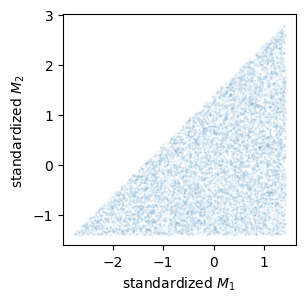

In [121]:
plt.figure(figsize=(3,3))
plt.scatter(*waveform_dataset.parameters.T,1,marker='.',alpha=.1)
plt.xlabel('standardized $M_1$')
plt.ylabel('standardized $M_2$')

**Q3 / What do the mass samples from the posterior look like before training?**

**Can we vizualize the velocity field before training?**

Following the mpl [docs](https://matplotlib.org/stable/gallery/lines_bars_and_markers/scatter_hist.html#sphx-glr-gallery-lines-bars-and-markers-scatter-hist-py) for the fancy plot layout :)

Text(0, 0.5, 'M1')

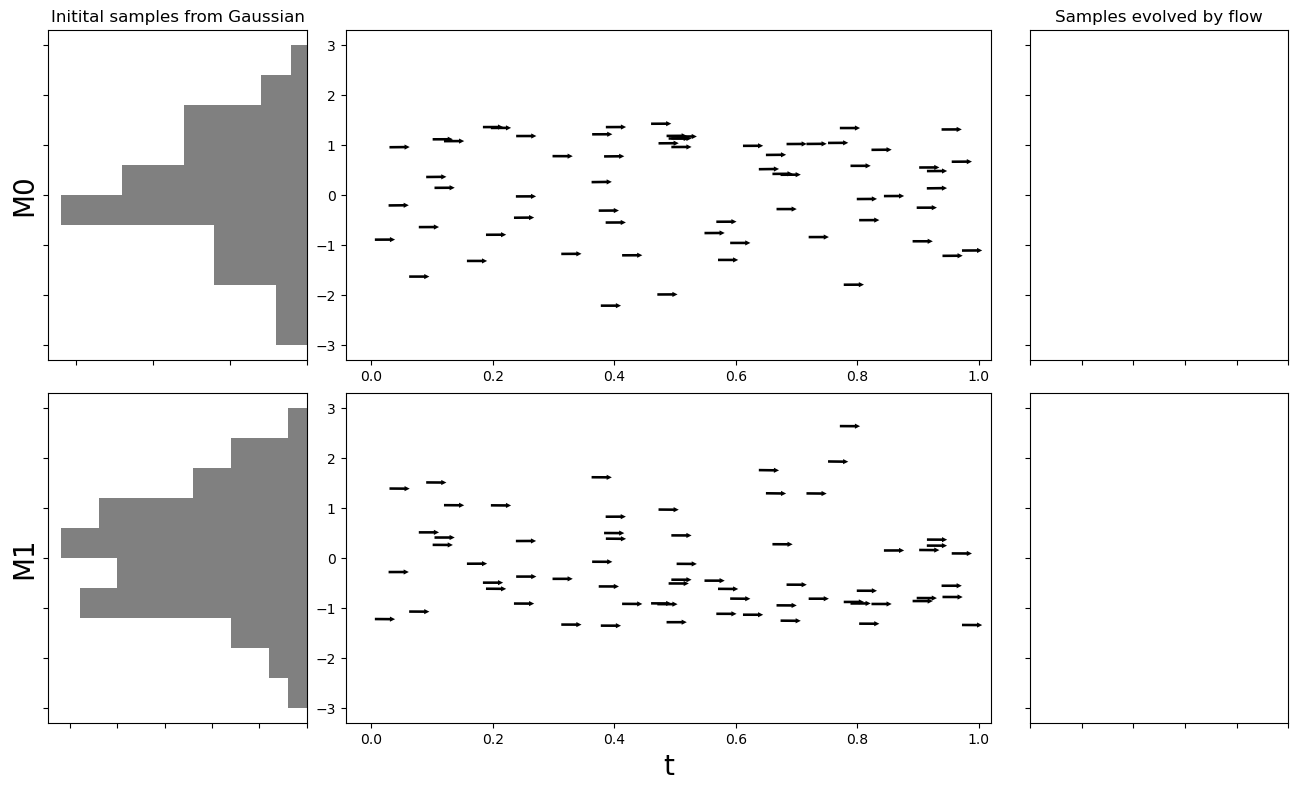

In [183]:
fig = plt.figure(figsize=(16,9))

# Add a gridspec with 3 rows and two columns and 
# a ratio of 1 to 3 to 1 between along the horizontal and
# 1 to 1 on the verical
gs = fig.add_gridspec(2, 3,  width_ratios=(1, 2.5, 1), height_ratios=(1, 1),
                      wspace=0.1, hspace=0.1
                     )
# Create the Axes.
ax11 = fig.add_subplot(gs[1,1])
ax10 = fig.add_subplot(gs[1,0],sharey=ax11)
ax12 = fig.add_subplot(gs[1,2],sharey=ax11)

ax01 = fig.add_subplot(gs[0,1],sharex=ax11)
ax00 = fig.add_subplot(gs[0,0],sharey=ax01)
ax02 = fig.add_subplot(gs[0,2],sharey=ax01)

kwargs = dict(angles='xy',scale_units='xy', scale=30,
              headwidth=2,headlength=2,headaxislength=2,
              width=.004)
ax01.quiver(t.squeeze().cpu(),theta[:,0].cpu(), np.ones(t.shape[0]), ut[:,0].detach().cpu(),
           **kwargs)
ax11.quiver(t.squeeze().cpu(),theta[:,1].cpu(), np.ones(t.shape[0]), ut[:,1].detach().cpu(),
           **kwargs)

ax11.set_xlabel('t',fontsize=20)

'''
Draw the samples @ the beginning + end of the trajectory.
These are the samples we'll transform to plot the posterior
'''
z = torch.randn((t.shape[0],param_dim)) 

# Turn off the tick labels bc we're sharing the mass axis anyways
for axi in [ax00,ax02,ax10,ax12]:
    axi.tick_params(axis="x", labelbottom=False)
    axi.tick_params(axis="y", labelleft=False)

ax00.hist(z[:,0], range=(-3,3),color='grey', orientation='horizontal')
ax10.hist(z[:,1], range=(-3,3),color='grey', orientation='horizontal')

# And to get the (?) to show up 
# https://stackoverflow.com/questions/67685927/how-to-create-a-horizontal-histogram-the-other-way-around
ax00.set_xlim(list(ax00.get_xlim())[::-1])
ax10.set_xlim(list(ax10.get_xlim())[::-1])

ax00.set_title('Initital samples from Gaussian')
ax02.set_title('Samples evolved by flow')

ax00.set_ylabel('M0',fontsize=20)
ax10.set_ylabel('M1',fontsize=20)


Text(0.5, 0, '$u_\\theta(x,y,t)$')

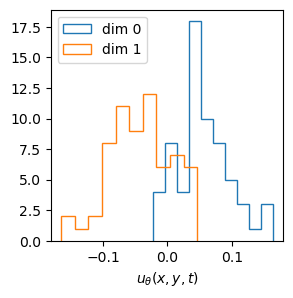

In [139]:
plt.figure(figsize=(3,3))
plt.hist(ut[:,0].detach().cpu(),histtype='step',label=r'dim 0')
plt.hist(ut[:,1].detach().cpu(),histtype='step',label=r'dim 1')
plt.legend()
plt.xlabel('$u_\theta(x,y,t)$')

OK, the velocity field just has a slope that is _too small_ to show up on the velocity plot above

### Training

In [51]:
# Training and test loops

def train_loop(dataloader, model, optimizer):

    model.train()
 
    size = len(dataloader.dataset)
    train_loss = 0
    
    for batch, (X, y) in enumerate(dataloader):
        # Compute negative log probability loss  
        loss = - model.log_prob(y, X)
        
        train_loss += loss.detach().sum()
        loss = loss.mean()

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if batch % 50 == 0:
            loss, current = loss.item(), batch * len(X)
            print(f"Loss: {loss:>7f}  [{current:>5d}/{size:>5d} samples]")
            
    average_loss = train_loss.item() / size
    print('Average loss: {:.4f}'.format(average_loss))
    return average_loss

        
def test_loop(dataloader, model):

    model.eval()
    
    size = len(dataloader.dataset)
    test_loss = 0

    with torch.no_grad():
        for X, y in dataloader:
            loss = - model.log_prob(y, X)
            test_loss += loss.sum()

    test_loss = test_loss.item() / size
    print(f"Test loss: {test_loss:>8f} \n")
    return test_loss

In [52]:
optimizer = torch.optim.Adam(model.parameters(), lr=3e-4, weight_decay=1e-5)

epochs = 20
train_history = []
test_history = []
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    loss = train_loop(train_dataloader, model, optimizer)
    train_history.append(loss)
    loss = test_loop(test_dataloader, model)
    test_history.append(loss)
print("Done!")

Epoch 1
-------------------------------
Loss: 3.299180  [    0/ 8000 samples]
Loss: 2.931100  [ 3200/ 8000 samples]
Loss: 3.747030  [ 6400/ 8000 samples]
Average loss: 3.1901
Test loss: 3.159393 

Epoch 2
-------------------------------
Loss: 3.360204  [    0/ 8000 samples]
Loss: 3.028874  [ 3200/ 8000 samples]
Loss: 2.715665  [ 6400/ 8000 samples]
Average loss: 3.0248
Test loss: 3.152295 

Epoch 3
-------------------------------
Loss: 2.677495  [    0/ 8000 samples]
Loss: 2.077930  [ 3200/ 8000 samples]
Loss: 3.116682  [ 6400/ 8000 samples]
Average loss: 2.7513
Test loss: 2.926626 

Epoch 4
-------------------------------
Loss: 2.912963  [    0/ 8000 samples]
Loss: 3.456975  [ 3200/ 8000 samples]
Loss: 3.473763  [ 6400/ 8000 samples]
Average loss: 3.3758
Test loss: 3.806072 

Epoch 5
-------------------------------
Loss: 3.826376  [    0/ 8000 samples]
Loss: 3.629593  [ 3200/ 8000 samples]
Loss: 3.902107  [ 6400/ 8000 samples]
Average loss: 3.6110
Test loss: 4.112212 

Epoch 6
-------

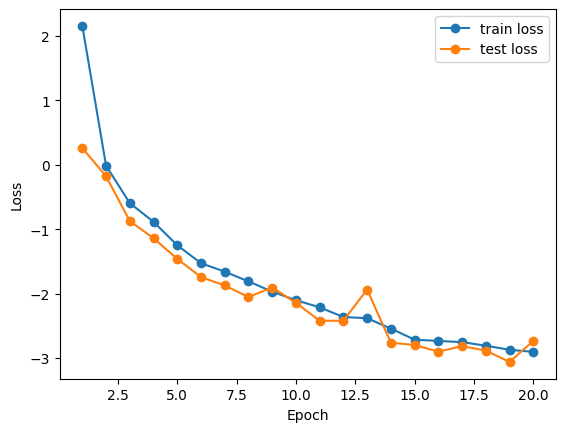

In [15]:
epochs = np.arange(1, len(train_history) + 1)
plt.plot(epochs, train_history, '-o', label = 'train loss')
plt.plot(epochs, test_history, '-o', label = 'test loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

### Visualize posteriors

[77.95061  56.157555]


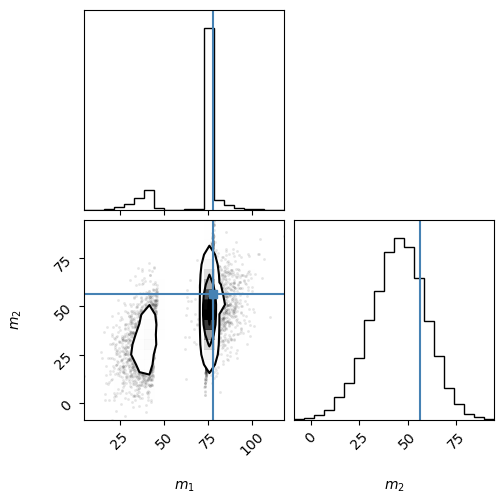

[65.44567 33.91634]


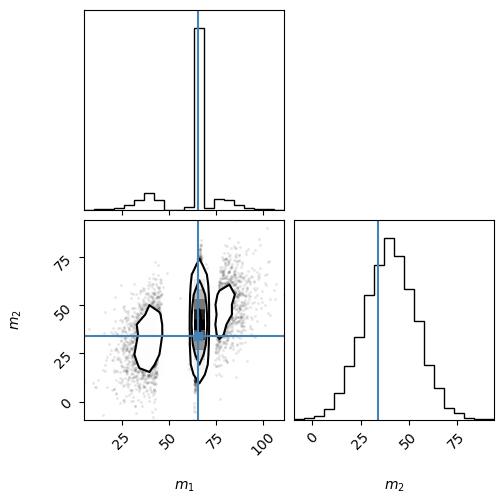

[38.104614 21.374651]


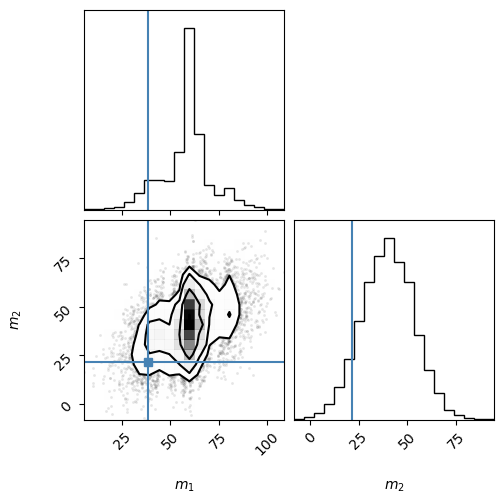

[49.256607 38.98138 ]


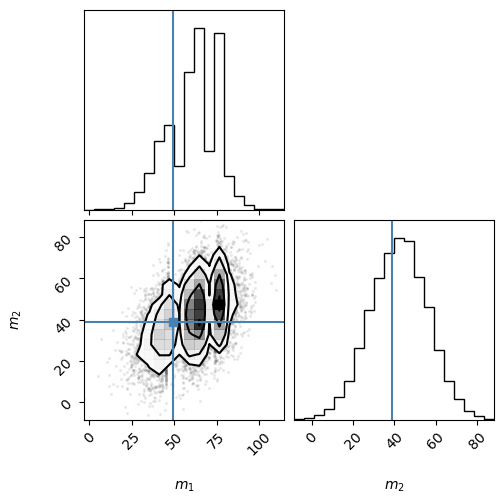

[60.044792 58.013027]


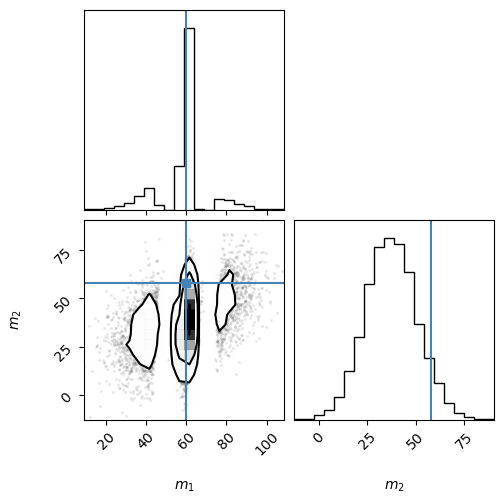

[71.807724 40.106506]


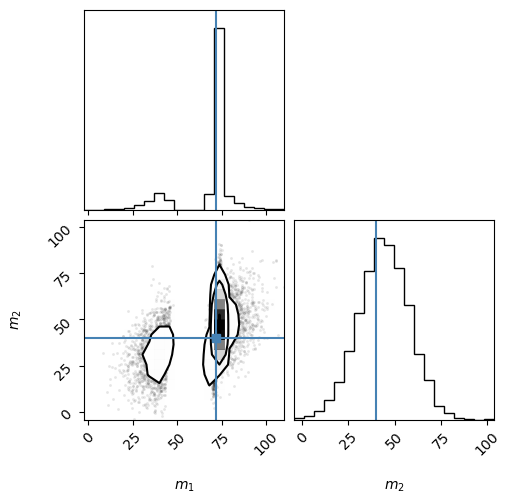

[64.86655  62.675285]


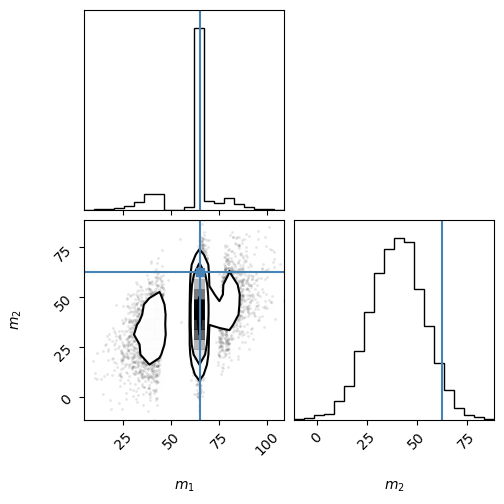

[61.52245  34.818184]


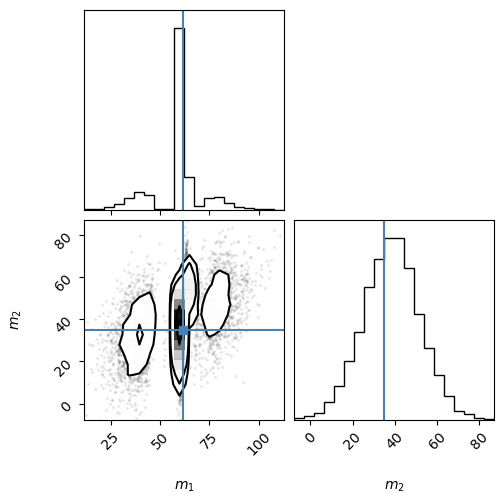

[62.18783 50.22635]


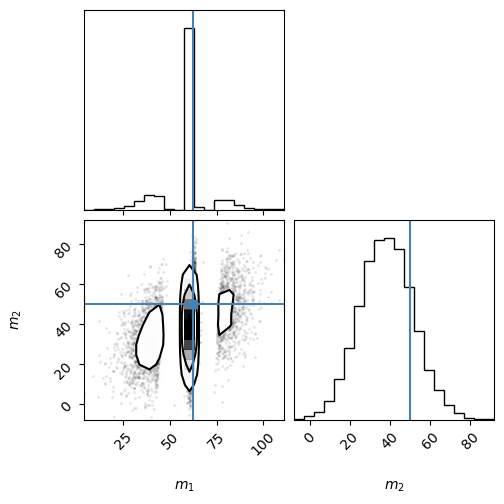

[56.943615 52.030796]


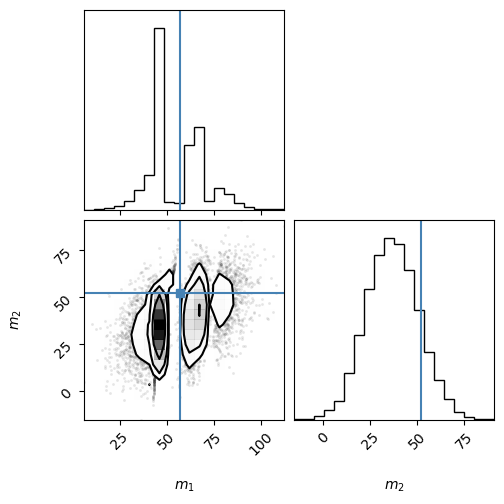

In [43]:
num_posteriors = 10
num_eval_samples = 10_000

model.eval()

for n in range(num_posteriors):

    with torch.no_grad():
    
        test_x, test_y = test_dataset[n]
       
        # Sample the posterior
        test_x = test_x.expand(num_eval_samples, *test_x.shape)
        pred_samples = model.sample(1, test_x).squeeze(1).cpu().numpy()
    
        # Undo the standardization
        pred_samples = parameters_std * pred_samples + parameters_mean
        truth = parameters_std * test_y.cpu().numpy() + parameters_mean
        print(truth)
    
        # Plot
        corner.corner(pred_samples, truths=truth, labels=['$m_1$', '$m_2$'])
        plt.show()